In [58]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import missingno as msno
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置-黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题
sns.set(font='SimHei')  # 解决Seaborn中文显示问题

In [59]:
'''
## 目标是根据人口普查核实数据
### 查看数据概览
#### 分别对各个数据中的字段进行合并，并进行整理
### 单变量分析
#### 新建两个集合，分别来计算把连续变量离散化和未离散化的数据
### 双变量分析
### 特征工程,数据清洗
* 结果标签观察
* 特征清洗分析
* 特征合并
* 特征构建
### 模型建立
'''
headers = ['age', 'workclass', 'fnlwgt', 
           'education', 'education-num', 
           'marital-status', 'occupation', 
           'relationship', 'race', 'sex', 
           'capital-gain', 'capital-loss', 
           'hours-per-week', 'native-country', 
           'predclass']
training_raw = pd.read_csv("dataset/adult.data",names=headers,header=None)
test_raw = pd.read_csv("dataset/adult.test",names=headers,header=None)

In [62]:
training_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [61]:
training_raw.describe(include=['O'])

,workclass,education,marital-status,occupation,relationship,race,sex,native-country,predclass
count,32561,32561,32561,32561,32561,32561,32561,32561,32561
unique,9,16,7,15,6,5,2,42,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [66]:
test_raw.head()


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,predclass
0,|1x3 Cross validator,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,25,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K.
2,38,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K.
3,28,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K.
4,44,Private,160323.0,Some-college,10.0,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States,>50K.


In [70]:
# 删除第一条错误数据
test_raw.drop(axis=0,index=0,inplace=True)
test_raw.age = test_raw.age.apply(np.float)
test_raw.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,16281.000000,1.628100e+04,16281.000000,16281.000000,16281.000000,16281.000000
mean,38.767459,1.894357e+05,10.072907,1081.905104,87.899269,40.392236
std,13.849187,1.057149e+05,2.567545,7583.935968,403.105286,12.479332
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.167360e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.778310e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.383840e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,3770.000000,99.000000


## 目标是根据人口普查数据，预测年收入是否可以大于5w一年

In [71]:
# 合并进行分析
dataset_raw = training_raw.append(test_raw,ignore_index=True)
dataset_raw.age = dataset_raw.age.apply(np.int)



### 单变量分析

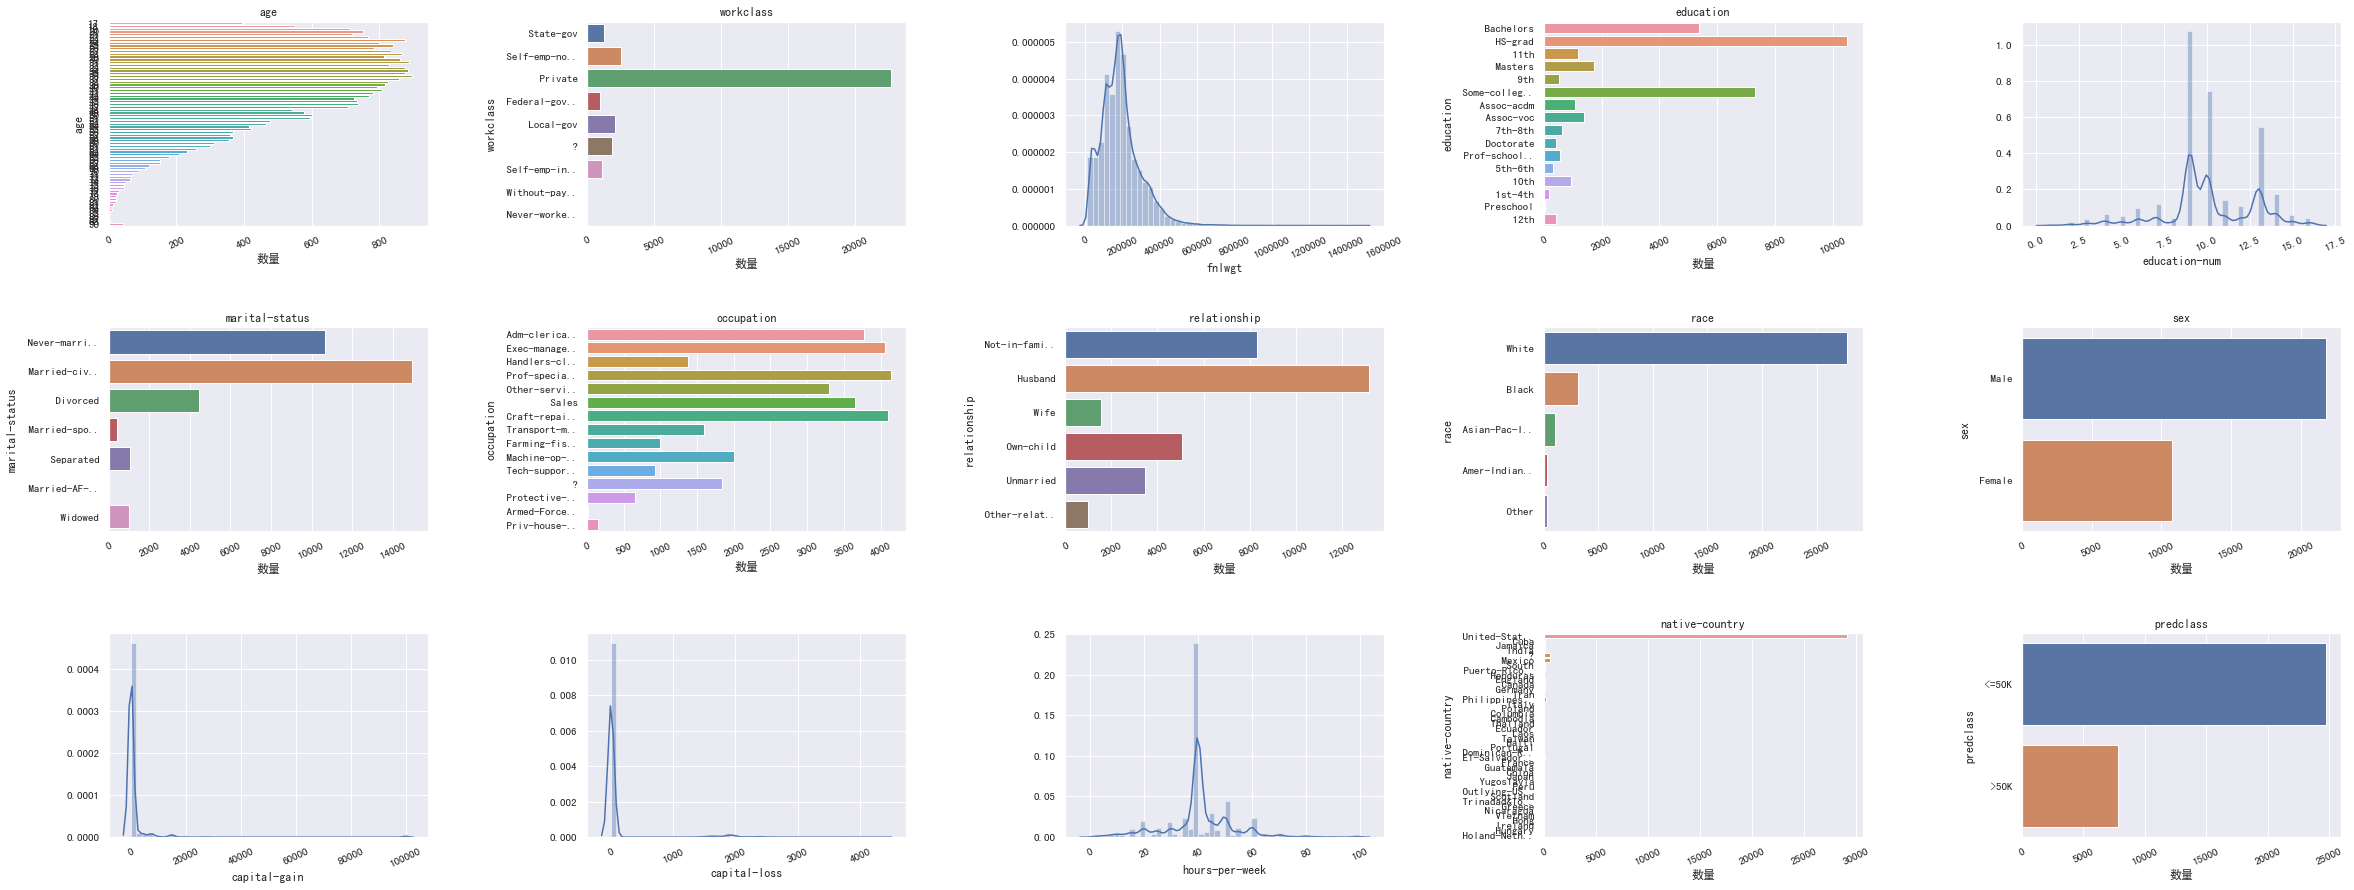

In [52]:
# 标签处理
def plot_distribution(dataset :pd.DataFrame,cols=3,width=40,height=15):
    rows = math.ceil(dataset.shape[1]/cols)
    plt.figure(figsize=(width,height))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for index,column in enumerate(dataset.columns):
        plt.subplot(rows,cols,index+1)
        plt.xticks(rotation=25)
        if dataset[column].dtype == np.object:
            g = sns.countplot(y=column,data=training_raw)
            g.set_title(column)
            g.set_xlabel("数量")
            g.set_yticklabels([i.get_text() if len(i.get_text()) < 12 else i.get_text()[0:12]+'..' for i  in g.get_yticklabels()])
        else:
            sns.distplot(training_raw[column])



plot_distribution(dataset=dataset_raw,cols=5)

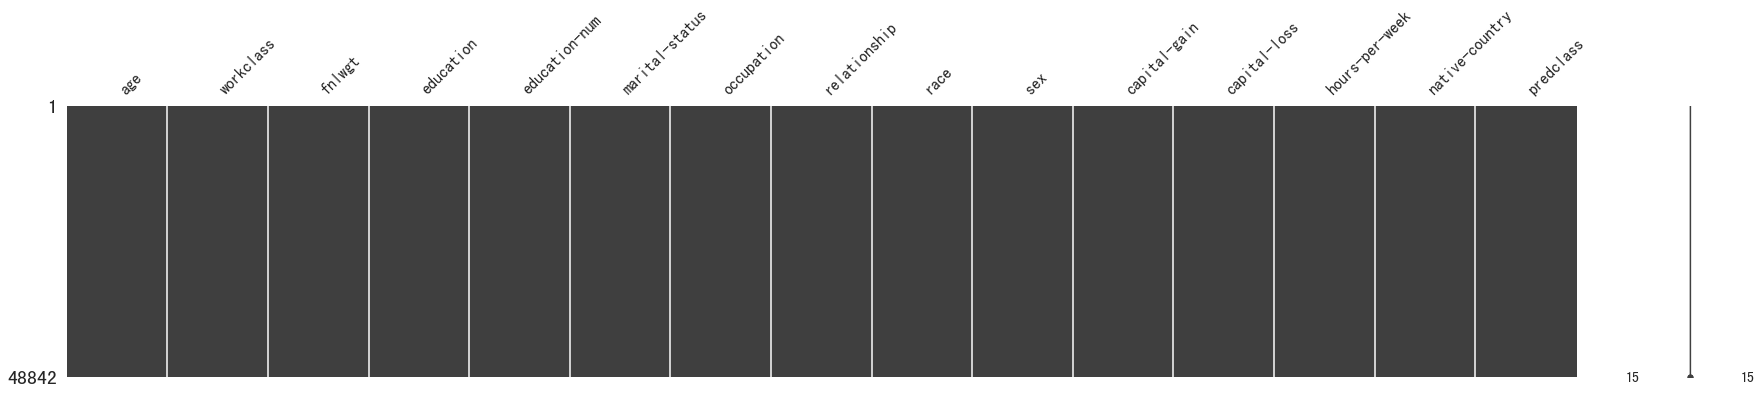

In [53]:
# 缺失值显示
msno.matrix(dataset_raw, figsize = (30,5))

In [72]:
# 新建两个集合，分别来计算把连续变量离散化和未离散化的数据
# 分别对各个数据中的字段进行合并，并进行整理
# 离散变量数据集
dataset_bin = pd.DataFrame()
# 连续变量数据集
dataset_con = pd.DataFrame()

In [54]:
dataset_raw.predclass.unique()

array([' <=50K', ' >50K', ' <=50K.', ' >50K.'], dtype=object)

### 双变量分析